# Example of analyzing a Zarr image from a public S3 repository

The images are taken from  the paper "In Toto Imaging and Reconstruction of Post-Implantation Mouse Development at the Single-Cell Level" published October 2018 in Cell: https://doi.org/10.1016/j.cell.2018.09.031

The images can be viewed online in the [Image Data Resource](http://idr.openmicroscopy.org/webclient/?show=project-502).

In [4]:
import zarr
import dask.array as da
import dask_image.ndfilters
import dask_image.ndmeasure
from omero.gateway import BlitzGateway

import matplotlib.pyplot as plt
%matplotlib inline

The Zarr data is stored separately from the IDR, on an S3 object store.

### IDR image to analyze

In [5]:
image_id = 4007801

### Create a connection to IDR

In [6]:
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Load image metadata from IDR

In [7]:
image = conn.getObject("Image", image_id)

### Load Zarr Image from S3

In [8]:
def load_binary_from_s3(id, resolution='4'):
    endpoint_url = 'https://s3.embassy.ebi.ac.uk/'
    root = 'idr/zarr/v0.1/%s.zarr/%s/' % (id, resolution)
    return da.from_zarr(endpoint_url + root)

In [9]:
data = load_binary_from_s3(image_id)
size_t = image.getSizeT()
size_z = image.getSizeZ()
%time plane = data[size_t//2, 0, size_z//2, :, :]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 617 µs


### Smooth the Image

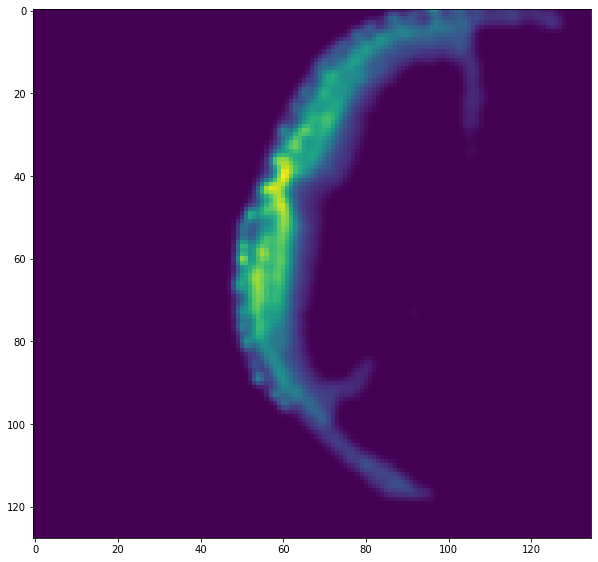

In [10]:
smoothed_image = dask_image.ndfilters.gaussian_filter(plane, sigma=[1, 1])
# Display image
plt.figure(figsize=(10, 10))
plt.imshow(smoothed_image, cmap='viridis')

### Segment the Image

360.0


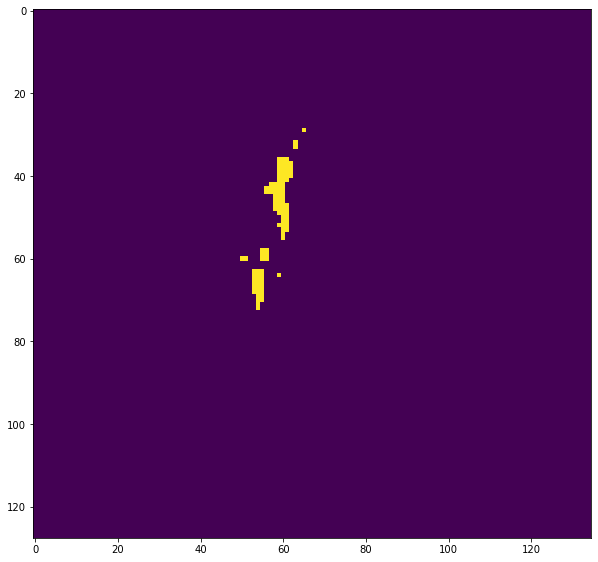

In [11]:
threshold_value = 0.75 * da.max(smoothed_image).compute()
print(threshold_value)
threshold_image = smoothed_image > threshold_value
plt.figure(figsize=(10, 10))
plt.imshow(threshold_image, cmap='viridis')

### Analyze

Number of labels: 7


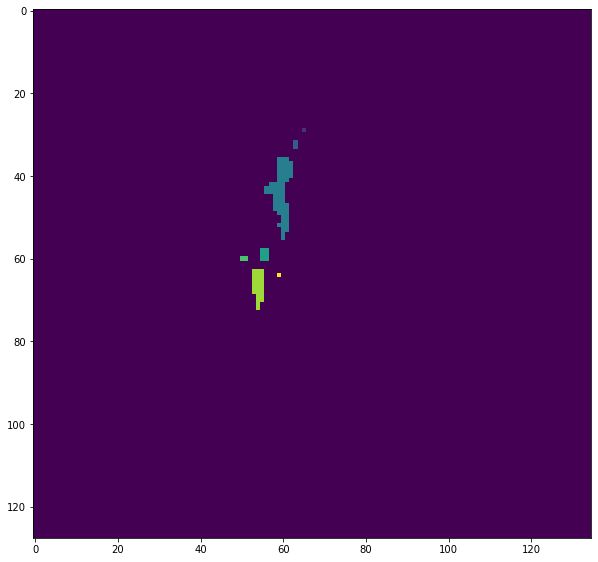

In [12]:
label_image, num_labels = dask_image.ndmeasure.label(threshold_image)
print("Number of labels:", int(num_labels))
plt.figure(figsize=(10, 10))
plt.imshow(label_image, cmap='viridis')

### Close the connection

In [13]:
conn.close()

### License
Copyright (C) 2020 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.